Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [ ]:
# import packages here
import utils
from visualization import Visualization as VIS
from ipywidgets import interact, fixed, widgets
from IPython.display import display, Image, clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jupyter_black

jupyter_black.load()

/home/steph/miniconda3/envs/NDS/lib/python3.10/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


## Context
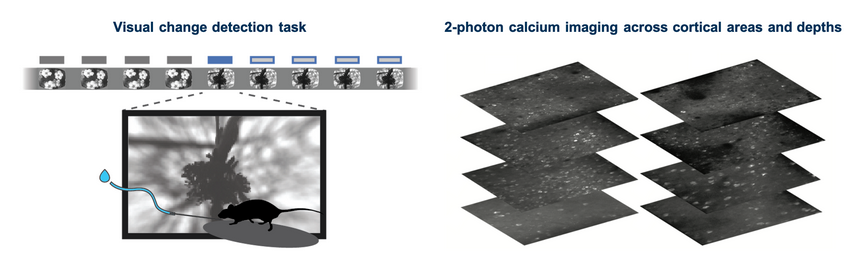

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

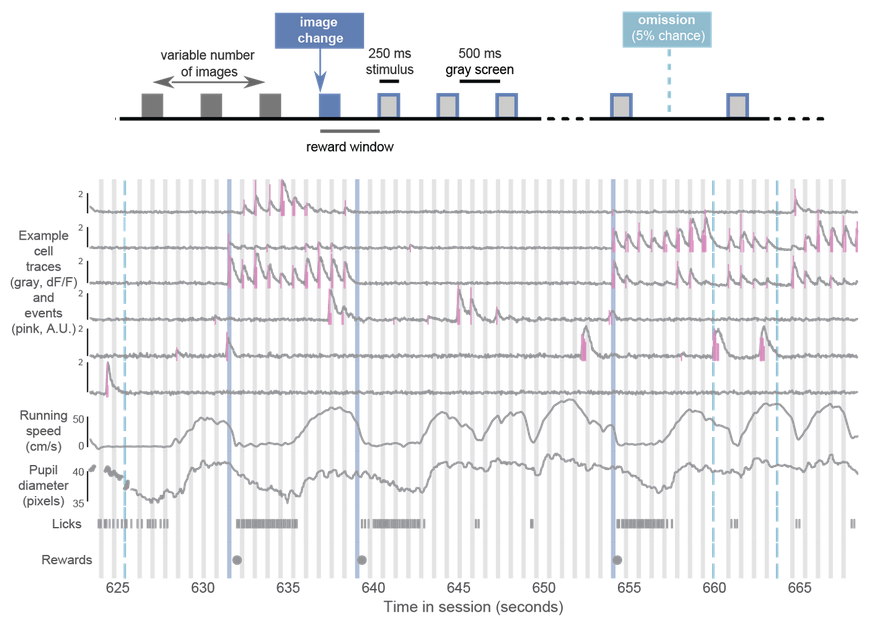

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [ ]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    print("Data keys: ", data.keys())
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Data keys:  dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



# 1. Data Exploration

TODO texte dazu schreiben

In [ ]:
# for visualization we use our self-written vis class to avoid clutter in this notebook.
# The data is passed to the class and assigned to variables like in this cell.
vis = VIS(data)

# assign data to variables for easier access
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]

# change stim_table "start" and "end" to int for easier indexing
stim_table["start"] = stim_table["start"].astype(int)
stim_table["end"] = stim_table["end"].astype(int)

# mean time difference in t
t_diff = np.mean(np.diff(t))
print(f"Mean time difference in t: {t_diff} s with sd: {np.std(np.diff(t))} s")

fs = 1 / t_diff  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Mean time difference in t: 0.03325489373863341 s with sd: 4.998870724556607e-06 s
Sampling frequency is 30.070762151865303 Hz, Time Interval is 0.03325489373863341 s


In [ ]:
# activity traces of the cells and the running speed of the mouse
interact(
    vis.update_raw_activity_traces_plot,
    cellIdx=vis.cell_index_slider(37),
    sample_range=vis.time_interval_slider(),
    show_epochs=vis.checkbox(value=True, description="Show epochs stimulus is shown"),
)

interactive(children=(IntSlider(value=37, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
# overview on how ofthen a unique stimulus variant is shown to the mouse
print(stim_table.groupby(["orientation", "temporal_frequency"]).size())

# mean duration and standard deviation a gratings stimulus is shown to the mouse
shown_gratings = stim_table[stim_table["blank_sweep"] == 0.0]
mean_time = np.mean(t[shown_gratings["end"]] - t[shown_gratings["start"]])
std_time = np.std(t[shown_gratings["end"]] - t[shown_gratings["start"]])
print(
    f"Mean duration a grating stimulus is shown: {mean_time} s with std: {std_time} s"
)

# some times a blank sweep is shown to the mouse, we can check how often this happens
print("Number of blank sweeps: ", stim_table["blank_sweep"].sum())

orientation  temporal_frequency
0.0          1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
45.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
90.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
135.0        1.0                   15
             2.0                   15
             4.0                   14
             8.0                   15
             15.0                  15
180.0        1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
225.0        1.0  

In [ ]:
# epochs the grating stimulus is shown to the mouse
stim_epoch_table

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


roi_masks shape:  (106, 512, 512)
roi_masks max:  1


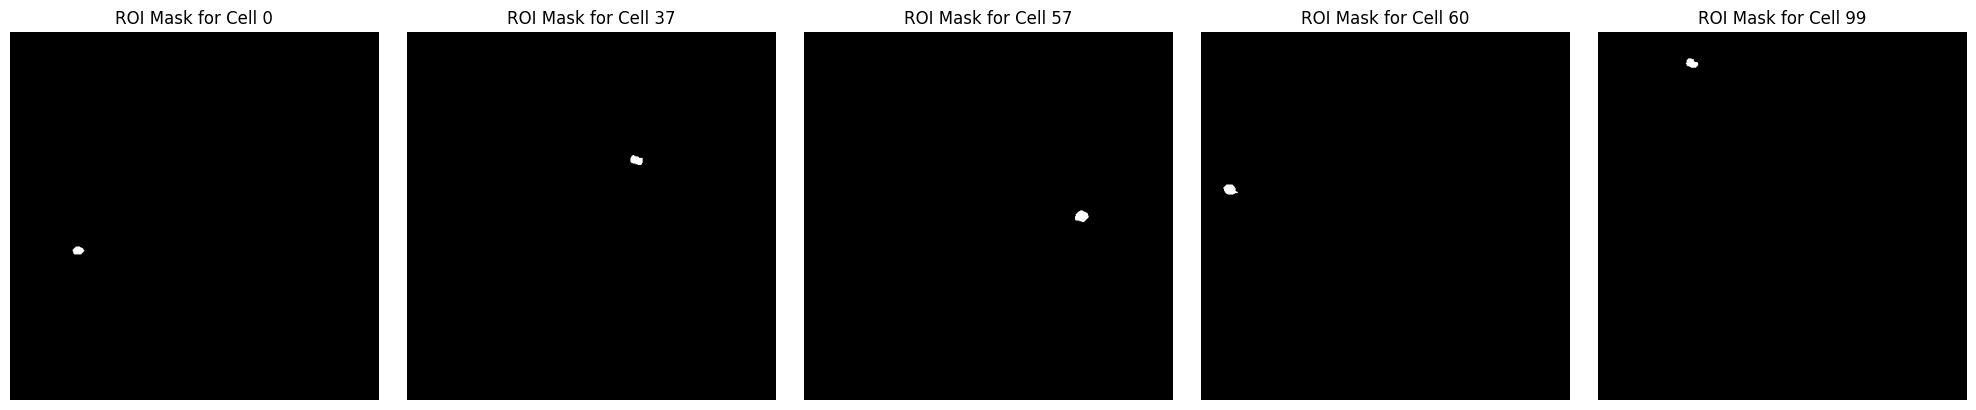

In [ ]:
# lets have a look at the ROI masks of the cells
print("roi_masks shape: ", roi_masks.shape)
print("roi_masks max: ", np.max(roi_masks))  # Values are from 0 to 1

# lets plot the masks of some cells
cells = [0, 37, 57, 60, 99]  # TODO select some nice cells
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, cell in enumerate(cells):
    axs[i].imshow(roi_masks[cell], cmap="gray")
    axs[i].set_title(f"ROI Mask for Cell {cell}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

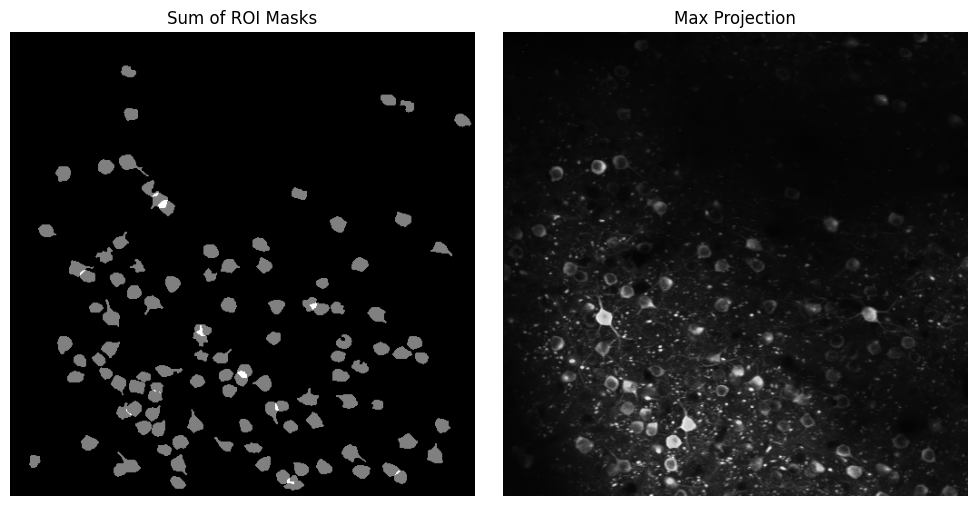

In [ ]:
# lets sum up the roi masks to get an overview of the cells and compare it to the max projection
roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(roi_masks_sum, cmap="gray")
axs[0].set_title("Sum of ROI Masks")

axs[1].imshow(max_projection, cmap="gray")
axs[1].set_title("Max Projection")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

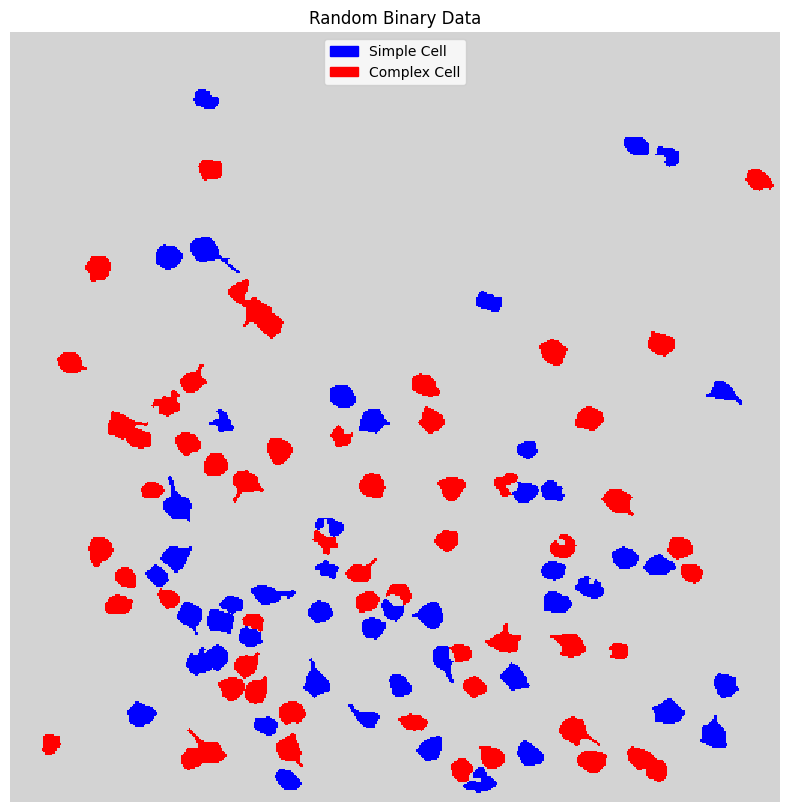

In [ ]:
# create a random binary array
random_data = np.random.randint(0, 2, roi_masks.shape[0])
vis.color_roi(random_data, "Random Binary Data", is_binary=True)

In [ ]:
# TODO insert exploration code and plots here!

# 2. Preprocessing

TODO add text here!

## 2.1 Process Data with OOPSI

TODO text

In [ ]:
# butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (fs / 2)

# create abs(dff)
# dff_abs[dff_abs < 0] = 0  # = np.abs(dff)
dff_butter = utils.butter_filter_signal(
    x=dff, low=low, high=high, fs=fs, order=4
)  # TODO play with parameters, ich weiß nicht mehr was die bedeuten

# as butterworth filter introduces negative values, we need to set them to zero
# dff_butter[dff_butter < 0] = 0

# wiener filter
window_wiener = 10  # TODO sollten wir hier eine windows size nehmen, die einer spike dauer entspricht?
dff_wiener = utils.wiener_filter_signal(x=dff, window=window_wiener)

# both filters applied sequentially
dff_both = utils.wiener_filter_signal(x=dff_butter, window=window_wiener)

In [ ]:
interact(
    vis.update_filter_traces_plot,
    cellIdx=vis.cell_index_slider(),
    sample_range=vis.time_interval_slider(),
    dff_butter=fixed(dff_butter),
    dff_wiener=fixed(dff_wiener),
    dff_both=fixed(dff_both),
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

TODO text zu OOPSI

In [ ]:
# we provide the processed data as a file
oopsi_from_file = True
if not oopsi_from_file:
    oopsi_spikes = utils.oopsi_inference(
        dff=dff_both, dt=dt, thresh=0.035, to_file=True
    )
else:
    oopsi_spikes = utils.load_inferred_spikes("../data/inference_oopsi.pkl")

for k in oopsi_spikes.keys():
    print(f"Key: {k}, Shape: {oopsi_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


Todo: Conclusion?

## 2.2 Process Data with OASIS

TODO Text -> Note: Filtering is not necessary as OASIS implements a filtering function.

- Thresholding wird auch von https://doi.org/10.1371/journal.pcbi.1005423 durchgeführt, liefert ganz gut Ergebnisse

In [ ]:
# this runs for a while. You can load the results from file in the cell below instead.
# If you want to run it, set from_file=False
from_file = True
if not from_file:
    oasis_spikes = utils.oasis_inference(dff=dff, to_file=True)
else:
    oasis_spikes = utils.load_inferred_spikes("../data/inference_oasis.pkl")

for k in oasis_spikes.keys():
    print(f"Key: {k}, Shape: {oasis_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


In [ ]:
interact(
    vis.update_inferred_spikes_plot,
    cellIdx=vis.cell_index_slider(),
    sample_range=vis.time_interval_slider(),
    show_oopsi=vis.checkbox(value=True, description="Show OOPSI"),
    show_oasis=vis.checkbox(value=True, description="Show OASIS"),
    oopsi_spikes=fixed(oopsi_spikes),
    oasis_spikes=fixed(oasis_spikes),
    input_trace=fixed(dff_both),  # input data for oopsi (oasis is raw data)
)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Cell Index:', layout=Layout(wid…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

TODO text zum Vergleich von OOPSI und OASIS und warum wir OASIS nehmen

In [ ]:
# as we use OASIS spikes, for the following analysis this is refered to as inferred_spikes
inferred_spikes = oasis_spikes

## 2.4 Intermediate Analysis

TODO Text!

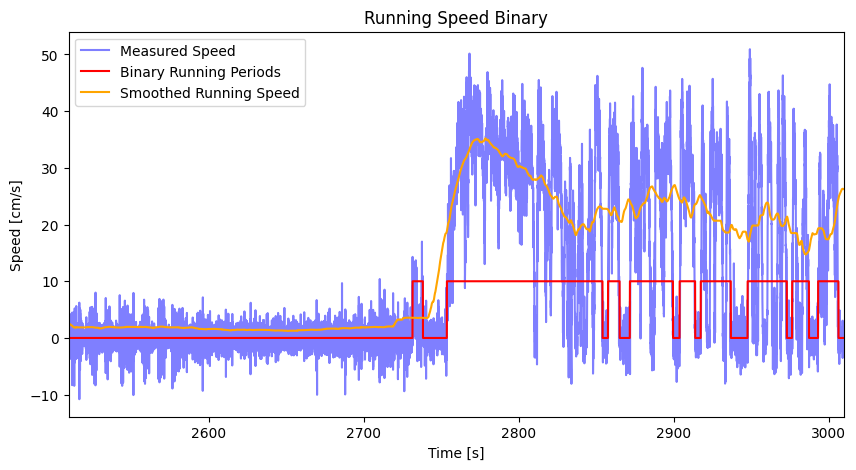

In [ ]:
# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)
# convolution und smoothing mit root mean squared error
# Window size: we apply quite heavy smoothing for better visualization --> between 500-1000 is feasible here
running_smooth = utils.window_rms(running_speed, 750)

vis.filtered_running_speed(2500, 3000, running_periods, running_smooth)

In [ ]:
# correlation between running periods and spikes
assert running_periods.shape[0] == inferred_spikes["binspikes"].shape[1]
utils.analyze_spike_running_correlation(inferred_spikes["binspikes"], running_periods)

(array([  0,   1,   3,   5,   7,   8,   9,  10,  11,  12,  13,  15,  18,
         19,  20,  21,  24,  25,  26,  29,  30,  32,  34,  40,  47,  48,
         50,  54,  58,  62,  69,  72,  74,  76,  77,  78,  80,  82,  83,
         84,  86,  87,  88,  93,  95,  96,  98,  99, 101, 102, 103, 104,
        105]),
 array([4.61165952e-002, 7.76282723e-010, 8.15978859e-001, 7.21932049e-007,
        1.00000000e+000, 1.58000039e-007, 8.42543331e-001, 1.18832361e-002,
        8.55758566e-046, 3.96410931e-009, 2.42982974e-015, 1.78344955e-007,
        3.23896283e-006, 2.96593783e-004, 1.00000000e+000, 1.59726923e-026,
        1.00000000e+000, 1.00000000e+000, 2.36879670e-003, 8.46233484e-003,
        2.32154851e-004, 7.80612814e-010, 6.37526435e-001, 1.00000000e+000,
        5.27305850e-163, 1.10119824e-002, 2.10359060e-104, 1.00000000e+000,
        1.00000000e+000, 4.87314690e-003, 5.93162084e-014, 1.00000000e+000,
        8.78796484e-028, 7.94136899e-002, 2.30637965e-002, 1.00000000e+000,
        7

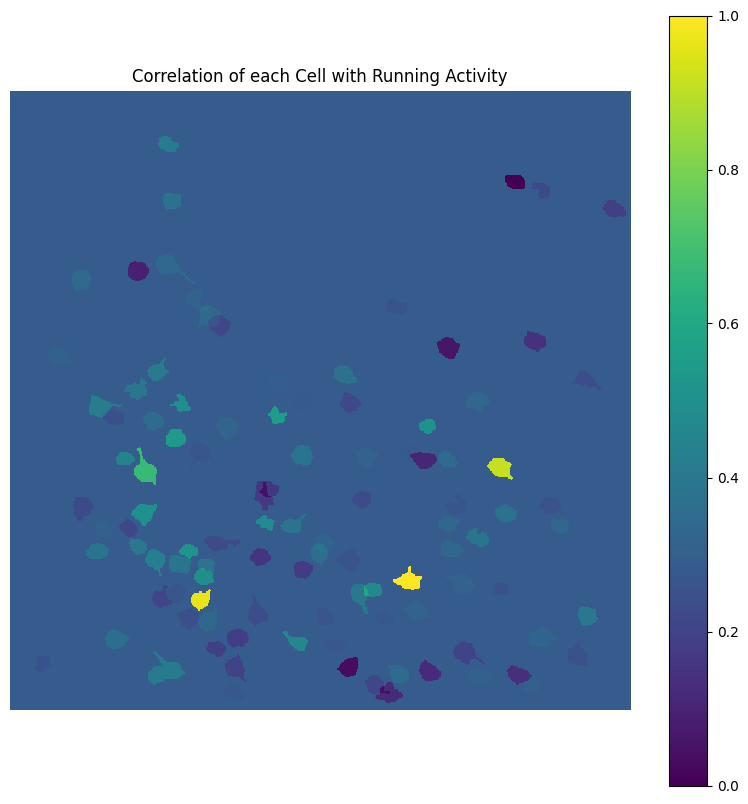

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu, pearsonr

roi_masks = data["roi_masks"].copy()
roi_masks_corr = np.zeros_like(roi_masks, dtype=np.float64)
for cell in range(roi_masks.shape[0]):
    corr, p = pearsonr(inferred_spikes["binspikes"][cell], running_speed)
    roi_masks_corr[cell, :, :] = np.where(
        roi_masks[cell, :, :].astype(np.float64) < 1, roi_masks[cell, :, :], corr
    )

roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

roi_masks_corr_sum = np.sum(roi_masks_corr, axis=0)
roi_masks_corr_sum = roi_masks_corr_sum / np.max(roi_masks_corr_sum)


fig, axs = plt.subplots(1, 1, figsize=(10, 10))
# axs.imshow(roi_masks_sum, cmap="gray", alpha=0.5)
axs.imshow(
    roi_masks_corr_sum, cmap="viridis", interpolation="none"
)  # TODO soll ich das als gescheiten plot machen? so gehts auf jeden fall nicht...
axs.set_title("Correlation of each Cell with Running Activity")
axs.axis("off")
# show color bar
plt.colorbar(plt.cm.ScalarMappable(cmap="viridis"), ax=axs)


plt.show()

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

In [ ]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # Convert theta to radians
    theta_rad = np.deg2rad(θ)
    phi_rad = np.deg2rad(ϕ)

    f = np.exp(
        α
        + κ * (np.cos(2 * (theta_rad - phi_rad)) - 1)
        + ν * (np.cos(theta_rad - phi_rad) - 1)
    )
    return f

In [ ]:
from scipy.optimize import curve_fit


def tuningCurve(
    counts: np.ndarray, dirs: np.ndarray, show: bool = True, neuron: int = 0
) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.

    neuron: int, default=0
        id of the plotted neuron (we added this for a nicer plot)

    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    # Initial guess for the parameters
    initial_guess = [np.mean(counts), 1, 1, np.median(dirs)]

    # Perform the non-linear least squares fit
    bounds = ([-np.inf, -np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf, 360])
    popt, _ = curve_fit(
        vonMises, dirs, counts, p0=initial_guess, bounds=bounds, maxfev=5000
    )

    if show:
        # Plot the data and fitted tuning curve
        fig, ax = plt.subplots(figsize=(7, 5))

        # Plot individual trial data
        ax.scatter(dirs, counts, label="Individual Trials", color="blue", s=15)

        # Plot average spike count per direction
        unique_dirs = np.unique(dirs)
        mean_counts = [np.mean(counts[dirs == d]) for d in unique_dirs]
        ax.plot(
            unique_dirs,
            mean_counts,
            label="Mean Spike Count",
            color="orange",
            linewidth=2,
            alpha=0.7,
        )

        # Plot fitted tuning curve
        fitted_curve = vonMises(unique_dirs, *popt)
        ax.plot(
            unique_dirs,
            fitted_curve,
            label="Fitted von Mises Curve",
            color="red",
            linestyle="--",
        )

        ax.set_xticks(np.arange(0, 361, 45))
        ax.set_xlim(0, 360)
        ax.set_xlabel("Direction [deg]")
        ax.set_ylabel("Spike Count")
        ax.set_title("Tuning Curve Fit of Neuron {}".format(neuron))
        ax.legend()
        plt.show()

    return popt

In [ ]:
def get_data(stim_table, spikes, neuron):
    spike_count = np.zeros(len(stim_table["start"]))
    for i in range(len(stim_table)):
        start = stim_table["start"][i].astype(int)
        end = stim_table["end"][i].astype(int)
        spike_count[i] = np.sum(spikes["binspikes"][neuron, start:end])

    return spike_count

counts.size:  598
dirs.size:  598


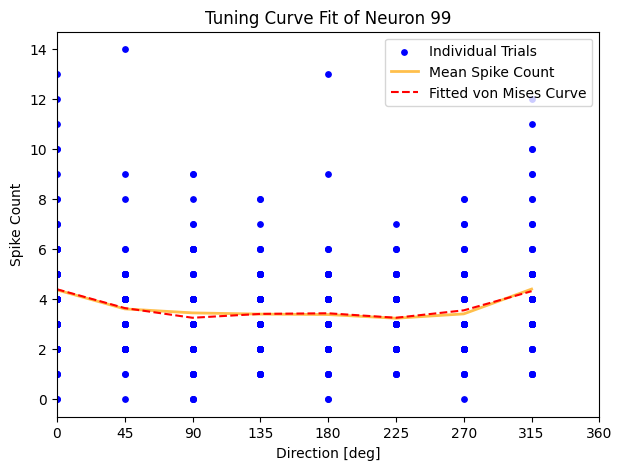

array([ 1.24646284e+00,  8.57575358e-02, -1.30743481e-01,  1.60503377e+02])

In [ ]:
cellIdx = 99

spike_count = get_data(stim_table, inferred_spikes, neuron=cellIdx)
spike_count = spike_count[stim_table["orientation"].dropna().index]

tuningCurve(
    spike_count, stim_table["orientation"].dropna(), neuron=cellIdx
)  # np.nan_to_num(stim_table["orientation"], nan=-99) # TODO Idee, frequenz reinbringen

In [ ]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
    neuron: int = 0,
) -> tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    neuron: int, default=0
        id of the plotted neuron (we added this for a nicer plot)

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # Convert directions to radians
    theta_k = np.deg2rad(np.unique(dirs))
    unique_dirs = np.unique(dirs)
    m_k = np.array([np.mean(counts[dirs == d]) for d in unique_dirs])
    v_k = np.exp(psi * 1j * theta_k)
    q = np.abs(np.dot(m_k, v_k))

    rng = np.random.default_rng(random_seed)
    qdistr = np.zeros(niters)

    for i in range(niters):
        shuffled_counts = rng.permutation(counts)
        shuffled_m_k = np.array(
            [np.mean(shuffled_counts[dirs == d]) for d in unique_dirs]
        )
        qdistr[i] = np.abs(np.dot(shuffled_m_k, v_k))

    p = np.sum(qdistr >= q) / niters

    if show:
        fig, ax = plt.subplots(figsize=(7, 4))
        ax.hist(qdistr, bins=30, color="skyblue", edgecolor="black", alpha=0.7)
        ax.axvline(q, color="red", linestyle="--", label=f"Observed |q| = {q:.2f}")
        ax.set_xlabel("|q| Values")
        ax.set_ylabel("Frequency")
        ax.set_title(
            "Permutation Test for Direction Tuning of Neuron {}".format(neuron)
        )
        ax.set_xlim(left=0)
        ax.legend()
        plt.show()

    return p, q, qdistr

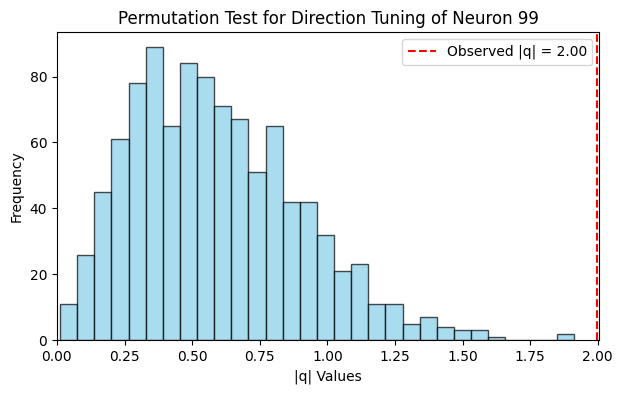

In [ ]:
# spike_count = get_data(stim_table, inferred_spikes, neuron=0) # REDUNDANT!!!
p, q, qdistr = testTuning(
    spike_count,
    stim_table["orientation"].dropna(),  # np.nan_to_num(, nan=-99),
    show=True,
    neuron=cellIdx,
)

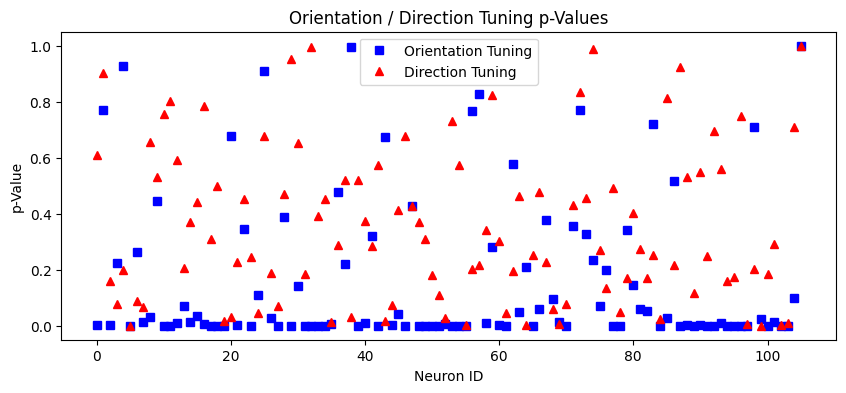

In [ ]:
neurons = inferred_spikes["binspikes"].shape[0]
p_orientation = np.zeros(neurons)
p_direction = np.zeros(neurons)
for neuron in range(neurons):
    counts = get_data(stim_table, inferred_spikes, neuron=neuron)
    counts = counts[stim_table["orientation"].dropna().index]
    p, q, qdistr = testTuning(
        counts,
        stim_table["orientation"].dropna(),
        psi=2,
        show=False,  # np.nan_to_num(stim_table["orientation"], nan=-99)
    )
    p_orientation[neuron] = p

# direction sensitivity is psi = 1
for neuron in range(neurons):
    counts = get_data(stim_table, inferred_spikes, neuron=neuron)
    counts = counts[stim_table["orientation"].dropna().index]
    p, q, qdistr = testTuning(
        counts,
        stim_table["orientation"].dropna(),
        psi=1,
        show=False,  # np.nan_to_num(stim_table["orientation"], nan=-99)
    )
    p_direction[neuron] = p

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    p_orientation, marker="s", linestyle="None", label="Orientation Tuning", color="b"
)  # Square marker, blue color
ax.plot(
    p_direction, marker="^", linestyle="None", label="Direction Tuning", color="r"
)  # Triangle marker, red color
ax.set_xlabel("Neuron ID")
ax.set_ylabel("p-Value")
ax.set_title("Orientation / Direction Tuning p-Values")
ax.legend(frameon=True)
plt.show()

In [ ]:
boundary = 0.001
n_direction_tuned = np.sum(p_direction <= boundary)
print(f"Number of direction tuned neurons: {n_direction_tuned}")
print(f"Neurons: {np.where(p_direction <= boundary)[0].tolist()}")

Number of direction tuned neurons: 2
Neurons: [5, 99]


In [ ]:
n_orientation_tuned = np.sum(p_orientation <= boundary)
print(f"Number of orientation tuned neurons: {n_orientation_tuned}")
print(f"Neurons: {np.where(p_orientation <= boundary)[0].tolist()}")
# NOTE WIE KANN ES SEIN; DASS DIE 63 hier nicht vorkommt?

Number of orientation tuned neurons: 43
Neurons: [0, 5, 10, 11, 17, 18, 19, 23, 27, 29, 31, 32, 33, 34, 39, 42, 44, 46, 48, 49, 50, 51, 53, 54, 55, 60, 61, 65, 70, 77, 78, 84, 87, 89, 91, 92, 94, 95, 96, 97, 100, 102, 103]


In [ ]:
def get_spike_times_cell(
    spikes: np.array,
    cell: int,
    stim_table: pd.DataFrame,
    orientation: float = 0.0,
    frequency: float = 1.0,
    blank_sweep=False,
) -> np.array:
    """
    Get the spike times for a given orientation and frequency for a specific cell.

    Parameters
    ----------
    spikes: np.array, (n_cells, n_samples)
        The spike counts for all cells.
    cell: int
        The index of the cell.
    stim_table: pd.DataFrame
        The table containing the start and end time index of each stimulus epoch.
    orientation: float
        The orientation of the drifting grating stimulus in degrees.
    frequency: float
        The frequency of the drifting grating stimulus in Hz.
    blank_sweep: bool
        If True, return the spike times for the blank sweep periods.

    Returns
    -------
    spike_times: np.array, (n_spikes, 2)
        spike_times[:, 0] contains the time index of the spikes
        spike_times[:, 1] contains the intensity of the spikes
    """
    # get epochs the stimulus is shown
    if not blank_sweep:
        stimulus_epochs = stim_table[
            (stim_table["orientation"] == orientation)
            & (stim_table["temporal_frequency"] == frequency)
        ]
    else:
        stimulus_epochs = stim_table[stim_table["blank_sweep"] == 1.0]

    # create binary mask for the entire experiment time with 1s for the stimulus epochs
    epochs_mask = np.zeros(spikes.shape[1], dtype=int)
    for idx, epoch in stimulus_epochs.iterrows():
        epochs_mask[int(epoch["start"]) : int(epoch["end"])] = 1

    # match the epochs mask with the cells spike train by mutliplying them elementwise
    cell_spikes = spikes[cell] * epochs_mask

    # store indices where cell_spikes is not zero using argwhere
    spike_indices = np.argwhere(cell_spikes > 0).flatten().astype(int)

    # remove zero entries from cell_spikes
    cell_spikes = cell_spikes[cell_spikes > 0]

    # check if cell_spikes has the same length as spike_indices
    assert len(cell_spikes) == len(spike_indices)

    # create the spike times array
    spike_times = np.zeros((len(cell_spikes), 2))
    spike_times[:, 0] = spike_indices
    spike_times[:, 1] = cell_spikes
    return spike_times

In [ ]:
from ipywidgets import IntSlider, FloatRangeSlider, Layout, interact
import matplotlib.transforms as transforms

orientations = np.unique(stim_table["orientation"].dropna())
temporal_frequencies = np.unique(stim_table["temporal_frequency"].dropna())
orientations.sort()
temporal_frequencies.sort()
y_step = len(temporal_frequencies) + 1
# create color array of y_step distinguishable colors
colors = plt.cm.tab10(np.arange(0, y_step))


# Define the function to update the plot
def update_plot(cellIdx, sample_range):
    start = max(int(sample_range[0] * fs), 0)
    end = min(int(sample_range[1] * fs), len(t) - 1)
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    for i, ori in enumerate(orientations):
        for j, freq in enumerate(temporal_frequencies):
            cell_spike_times = get_spike_times_cell(
                inferred_spikes["spikes"], cellIdx, stim_table, ori, freq
            )
            cell_spike_times_in_range = cell_spike_times[
                (cell_spike_times[:, 0] >= start) & (cell_spike_times[:, 0] <= end)
            ]
            axs.scatter(
                t[cell_spike_times_in_range[:, 0].astype(int)],
                np.zeros_like(cell_spike_times_in_range[:, 1]) + (i * y_step) + j + 0.5,
                color=colors[j],
                s=5,
                marker="|",
                label=f"{freq} Hz" if i == 0 else "",
            )

    # x-axis
    axs.set_xlim(t[start], t[end] + 30)
    axs.set_xlabel("Time [s]")

    # y-axis
    axs.set_ylim(0, len(orientations) * y_step)
    axs.set_yticks(np.arange(len(orientations) * y_step, step=y_step))
    axs.set_yticklabels(orientations)
    axs.set_ylabel("Direction [°]")
    for tick_label in axs.get_yticklabels():
        tick_label.set_transform(
            tick_label.get_transform()
            + transforms.ScaledTranslation(0, 0.18, fig.dpi_scale_trans)
        )

    axs.set_title(f"Spike Times of Cell {cellIdx} for Different Orientations")
    axs.grid(axis="y", alpha=0.5)
    # place legend outside on the right of the plot
    plt.legend(
        title=f" Temporal\n Frequency",
        title_fontsize="medium",
        loc="center left",
        bbox_to_anchor=(1, 0.5),
    )

    plt.show()


# Create an IntSlider for selecting time range
sample_slider = FloatRangeSlider(
    value=[0.0, t[-1]],  # Initial value [a, b]
    min=0.0,  # Minimum value A
    max=t[-1],  # Maximum value B
    step=dt,  # Step size
    description="Time Range [s]:",  # Slider label
    continuous_update=False,  # Update plot only on releasing the slider
    layout=Layout(width="99%"),  # Adjust the layout width
)

# Create an IntSlider for selecting cellIdx
cell_slider = IntSlider(
    value=57,  # Initial value
    min=0,  # Minimum value
    max=inferred_spikes["spikes"].shape[0]
    - 1,  # Maximum value based on number of cells
    step=1,  # Step size
    description="Cell Index:",  # Slider label
    continuous_update=False,  # Update plot only on releasing the slider
    layout=Layout(width="99%"),  # Adjust the layout width
)

# Use interact to link the slider to the update function
interact(update_plot, cellIdx=cell_slider, sample_range=sample_slider)

interactive(children=(IntSlider(value=57, continuous_update=False, description='Cell Index:', layout=Layout(wi…

<function __main__.update_plot(cellIdx, sample_range)>

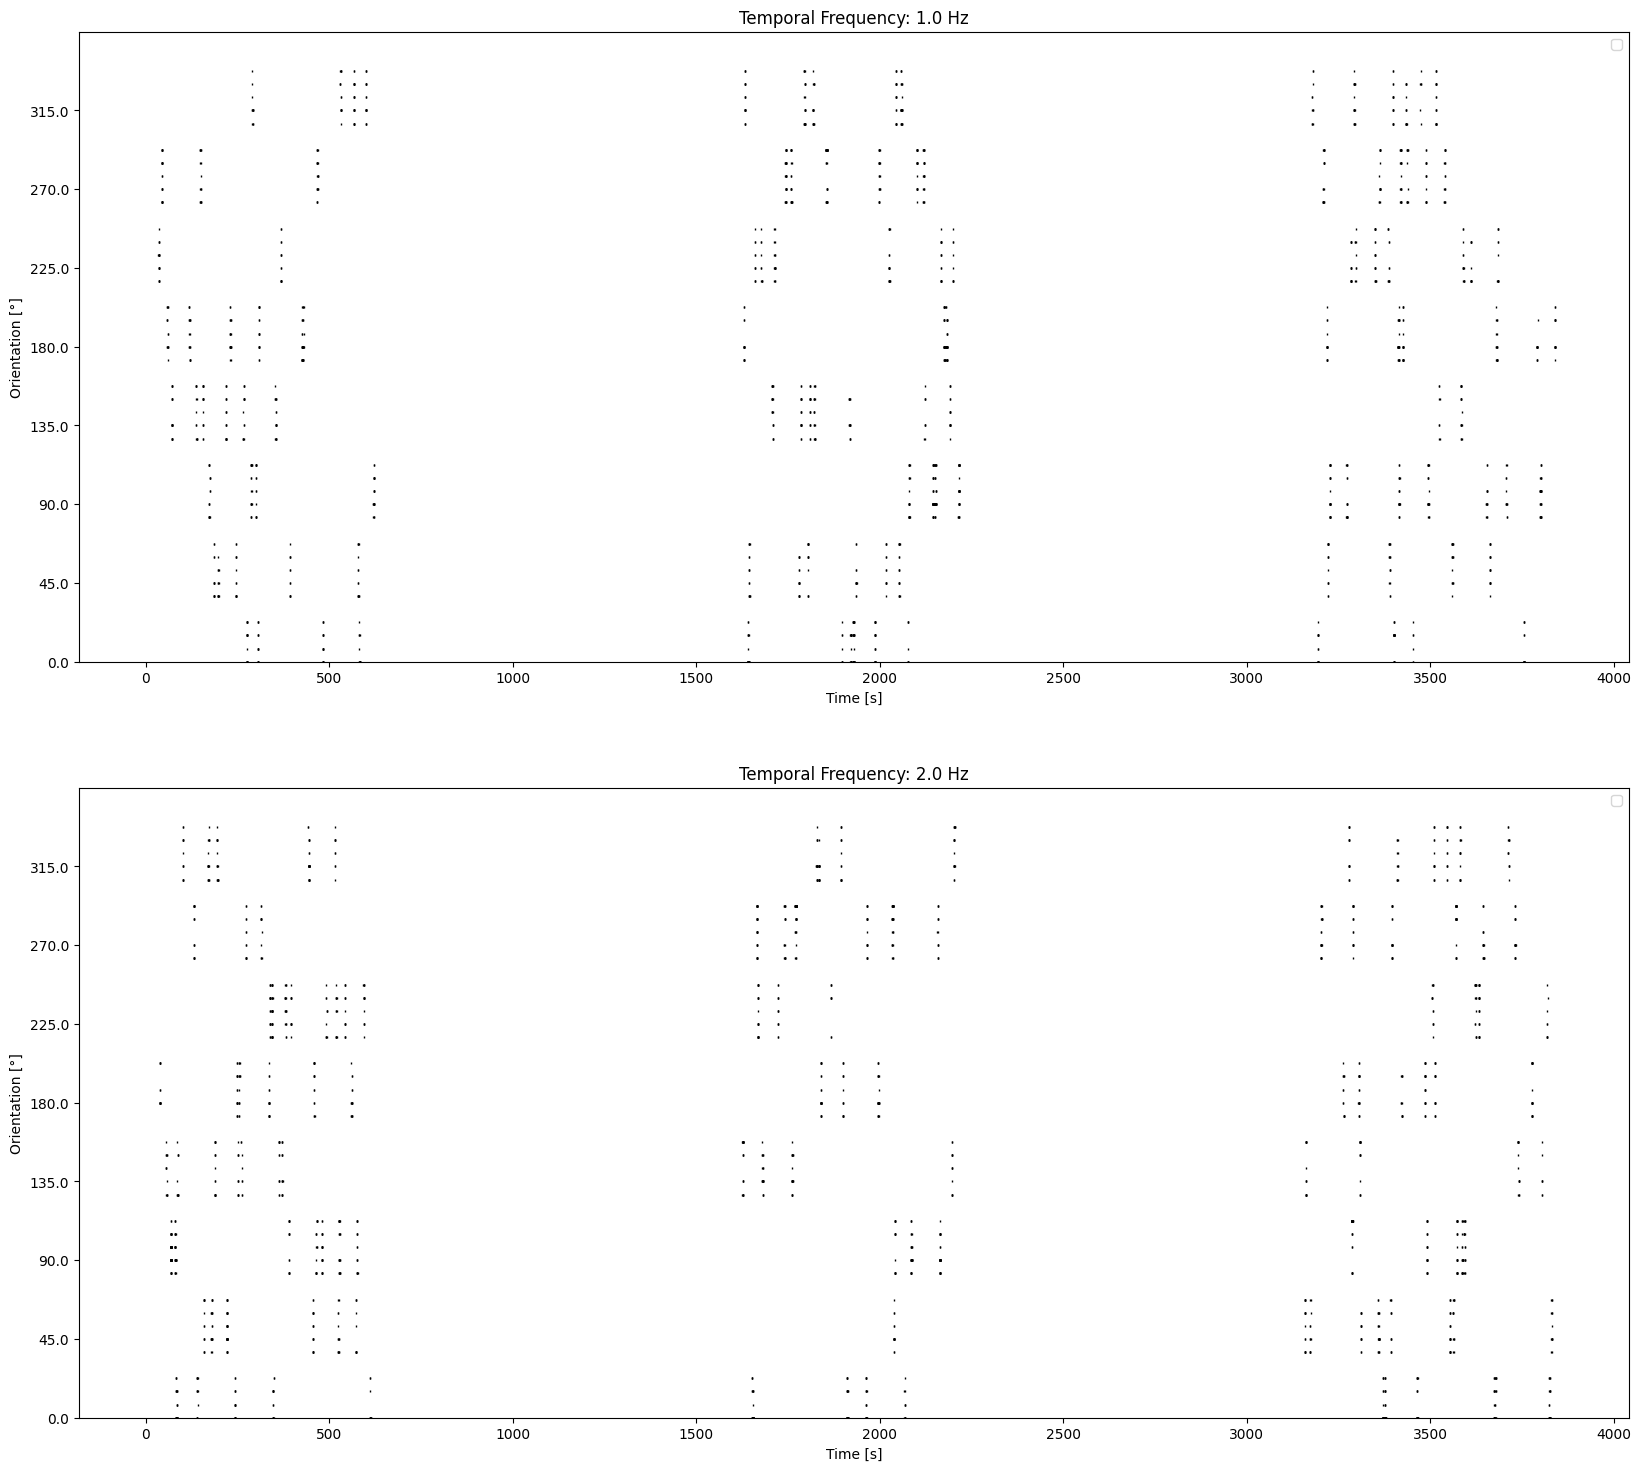

In [ ]:
# get spike times per orientation and temporal frequency per cell
temporal_frequencys = [1.0, 2.0]  # np.unique(stim_table["temporal_frequency"].dropna())
orientations = np.unique(stim_table["orientation"].dropna())
cells = [0, 5, 50, 75, 100]
temporal_frequencys.sort()
orientations.sort()

fig, axs = plt.subplots(
    len(temporal_frequencys),
    1,
    figsize=(20, len(temporal_frequencys) * (len(orientations) + 1)),
)
y_dist = len(cells) + 1
for i, freq in enumerate(temporal_frequencys):

    for j, ori in enumerate(orientations):
        filtered_spikes = utils.get_spike_times(
            inferred_spikes["binspikes"], stim_table, ori, freq
        )

        for k, cell in enumerate(cells):
            axs[i].plot(
                t,
                (filtered_spikes[cell] * ((j * y_dist) + (k * filtered_spikes[cell]))),
                marker="|",
                linestyle="None",
                color="k",
                markersize=2,
            )
    # also plot the blank sweep times
    # nan_spikes = utils.get_spike_times(
    #     inferred_spikes["binspikes"], stim_table, ori, freq, blank_sweep=True
    # )
    # for k, cell in enumerate(cells):
    #     axs[i].plot(
    #         t,
    #         nan_spikes[cell] + k + ((orientations[-1] + 45.0) * y_dist),
    #         marker="|",
    #         linestyle="None",
    #         color="gray",
    #         markersize=2,
    #         label="Blank Sweep",
    #     )

    axs[i].set_title(f"Temporal Frequency: {freq} Hz")
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Orientation [°]")
    # axs[i].set_xlim(0, t[-1])
    axs[i].set_ylim(0, len(orientations) * y_dist)
    axs[i].set_yticks(range(0, len(orientations) * y_dist, y_dist))
    axs[i].set_yticklabels(orientations)
    axs[i].legend()

plt.show()

Todo:

- plot oben zum laufen kriegen
- peri stimulius time plots aus CL4
- Unterschied direction / orientation? Wir haben orientation gegeben, in CL4 war direction of motion gegeben? 
--> muss man die tuning function anpassen? Wenn ja wie? 

*Antwort:* Orientation = Ausrichtung des Musters (statisch), Direction = Bewegungsrichtung des Musters. --> Tuning function muss nicht angepasst werden. 

- spatial structure: preferred orientation (max der tuning curve) einfärben (wenn signifikant?) = Direction?

- überlegen wie spatial frequency da rein kommt und warum temporal frequency gegeben wurde 

*Idee:* Für jede temporal frequency separat rechnen. Was spatial frequency sein soll kp, ich vermute die wellenlänge des stimulus. **Vorschlag** wir gehen einfach erstmal davon aus, dass temporal = spatial freq sein soll, da wir nix wissen über wellenlänge des stimulus oder geschwindigkeit.

- Complex / simple cells 


**Weitere Gedanken:**
- plane sweep zeiten als referenz?
- was ist mit den irrelevanten zeiträumen?
- shift der spikes wieder berücksichtigen?
- Histogram binning?
- Wann benutzen wir jetzt spikes und wann binspikes?

# Cell Graveyard

In [ ]:
# plot the detected spikes per cell and running speed
# Window
start = int(fs * 0)
end = len(t) - 1  # int(fs * 3600)

show_epochs = True
show_running = True

fig, axs = plt.subplots(figsize=(15, 10))
for cellIdx in range(dff.shape[0]):
    spike_train_cell = inferred_spikes["binspikes"][cellIdx, :]
    # create binary array for spikes and no spikes in spike train
    spike_binary = np.ones_like(spike_train_cell) * -50
    spike_binary[spike_train_cell == 1] = cellIdx
    axs.plot(
        t[start:end],
        spike_binary[start:end],
        marker="|",
        linestyle="None",
        color="k",
        markersize=2,
    )

# mark the epochs where the locally sparse noise stimulus is not shown
other_stimuli = utils.get_epochs_in_range(
    stim_epoch_table, start, end
)  # TODO zeiträume rausrechnen in denen nix gezeigt wird
if show_epochs and not other_stimuli.empty:
    for i in range(other_stimuli.shape[0]):
        ep_start = other_stimuli.iloc[i]["start"]
        ep_end = other_stimuli.iloc[i]["end"]
        if i == 0:
            axs.axvspan(
                t[ep_start], t[ep_end], color="gray", alpha=0.2, label="Other Stimulus"
            )
        else:
            axs.axvspan(t[ep_start], t[ep_end], color="gray", alpha=0.2)

# # mark the running periods with a red line
# running_epochs = utils.get_epochs_in_range(
#     utils.get_running_periods_table(running_periods), start, end
# )
# running_epochs = running_epochs[running_epochs["stimulus"] == "running"]
# if show_running and not running_epochs.empty:
#     for i in range(running_epochs.shape[0]):
#         r_start = running_epochs.iloc[i]["start"]
#         r_end = running_epochs.iloc[i]["end"]
#         if i == 0:
#             axs.axvspan(
#                 t[r_start], t[r_end], color="blue", alpha=0.3, label="Running Period"
#             )
#         else:
#             axs.axvspan(t[r_start], t[r_end], color="blue", alpha=0.3)

axs.plot(
    t[start:end],
    running_smooth[start:end] + dff.shape[0] + 1,
    color="red",
    label="Smoothed Running Speed",
)

# TODO: yticks ab dff.shape[0] und legende (rot = running speed) hin
axs.set_xlim(t[start] - 50, t[end] + 50)
axs.set_ylim(-1, dff.shape[0] + 30)
axs.set_xlabel("Time [s]")
axs.set_ylabel("Cell")
# if not running_epochs.empty or not other_stimuli.empty:
#     plt.legend()
plt.legend()
plt.show()